<a href="https://colab.research.google.com/github/JuanArmas/BigData7RO/blob/main/Cartpole_JuanArmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hay que tener en cuenta que no hay ningún controlador de pantalla disponible para generar vídeos en colab, sin embargo, es posible instalar un controlador de pantalla virtual para que funcione. Lo haremos por medio de la librería "pyvirtualdisplay"

In [50]:
# !pip install pyvirtualdisplay

##Importación de librerías

In [51]:
import os
import io
import gym
import random
import base64
import numpy as np
import matplotlib.pyplot as plt

from base64 import b64encode
from collections import deque
from keras.layers import Dense
from IPython.display import HTML
from keras.optimizers import Adam
from keras.models import Sequential
from pyvirtualdisplay import Display
from gym.wrappers.monitoring.video_recorder import VideoRecorder


##Cargamos el entorno  cartpole

In [52]:
# Configuración del entorno
env = gym.make('CartPole-v0')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


##Ahora comencemos a comprender este entorno observando el espacio de acción.

La salida Discrete(2) significa que hay dos acciones. En cartpole, 0 corresponde a "empujar el carrito hacia la izquierda" y 1 corresponde a "empujar el carrito hacia la derecha"

In [53]:
env.action_space

Discrete(2)

##Ahora creamos la clase DQAgent el cual, interactuará con el entorno.

la clase contendrá una serie de funciones que pasamos a detallar

__init__: Define el tamaño del espacio de estados (state_size) y el espacio de acciones (action_size). También inicializa la memoria para almacenar las experiencias pasadas, y configura los parámetros tasa de descuento (gamma), la probabilidad de exploración inicial (epsilon), y tasas de aprendizaje.

_build_model: Define y compila una red neuronal para estimar la función de valor Q. La red tiene capas de entrada y ocultas con activación ReLU, y una capa de salida con activación lineal para predecir los valores Q de cada acción.

Remember: Almacena las transiciones de experiencia (estado, acción, recompensa, próximo estado, done) en la memoria del agente.

Act: Decide la próxima acción a tomar dado un estado. Puede elegir una acción aleatoria con una probabilidad inicial (epsilon) para explorar, o seleccionar la acción con el valor Q más alto según la red neuronal.

Replay: Entrena la red neuronal utilizando muestras aleatorias de experiencias pasadas almacenadas en la memoria (self.memory). Calcula los objetivos de aprendizaje y actualiza los valores Q estimados.

Save y load: Permite guardar y cargar los pesos de la red neuronal en archivos, para persistir el modelo entrenado y reutilizarlo posteriormente.

In [54]:
# Clase del agente DQN
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

## Creación del agente
Contendrá unas dimensiones del espacio con el que interactuará y las acciones definidas en la clase del agente

In [55]:
# Crear agente DQN
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

## Entrenamiento del agente

En este paso, ejecutamos el entrenamiento del agente en el entorno. Durante cada episodio, el agente interactuará con el entorno, almacenará las experiencias en su memoria, y luego utilizará muestras de estas experiencias para entrenar su red neuronal. También se guardará periódicamente el progreso del agente mediante la persistencia de sus pesos en archivos almacenados en la carpeta de colab que se creará de manera dinámica, lo que permite reanudar el entrenamiento en el futuro si es necesario.


In [ ]:
# Entrenamiento del agente
n_episodes = 100
batch_size = 32
output_dir = 'cartpole/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

scores = []
epsilons = []

for e in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    for time in range(200):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            print("Episodio: {}/{}, Puntaje: {}, Epsilon: {:.2f}".format(e, n_episodes, time + 1, agent.epsilon))
            scores.append(time + 1)
            epsilons.append(agent.epsilon)
            break

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

    if e % 50 == 0:
        agent.save(output_dir + "weights_{:04d}.hdf5".format(e))

## Formateo/renderizado del vídeo
En este punto generamos dos maneras de formatear el vídeo.

generaremos dos funciones que lograrán el mismo resultado de mostrar un video MP4 en un entorno interactivo, pero tienen diferencias en la implementación y la forma en que se utilizan. El uso de dos funciones no es necesario, ya que cualquiera de las dos nos valdría, simplemente están para ver la versatilidad de esta herramienta y los resultados obtenidos.

show_video(video_path)
Mostrará un video en formato MP4 utilizando un elemento < video> en HTML incrustado en el entorno de colab.

In [57]:
def show_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))

render_mp4(videopath: str) -> str
Genera una cadena HTML que representa un elemento de video embebido con el video MP4 codificado en base64.

In [58]:
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

Diferencias:

- show_video(video_path) muestra directamente el video utilizando display(HTML(...)), mientras que render_mp4(videopath: str) -> str retorna una cadena HTML que representa el elemento de video.
- show_video(video_path) utiliza io.open para abrir el archivo de video en modo binario, mientras que render_mp4(videopath: str) -> str utiliza open directamente.
- show_video(video_path) utiliza base64.b64encode(video) para codificar el video en base64, mientras que render_mp4(videopath: str) -> str utiliza b64encode(mp4).decode().

# Creación y guardado del vídeo del último episodio

Usamos un VideoRecorder para grabar un video del último episodio ejecutado por el agente. Durante cada paso del episodio, el agente interactuará con el entorno, y se capturará un fotograma del entorno en cada paso para crear el video. Una vez finalizado el bucle, el video se guarda en el archivo especificado en videopath.

In [59]:
# Crear y guardar vídeo del último episodio
videopath = 'before_training.mp4'
video = VideoRecorder(env, videopath, enabled=True)
state = env.reset()
state = np.reshape(state, [1, state_size])
for i in range(200):
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    video.capture_frame()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadloc

1/1 [==============================] - 0s 26ms/step


# Cierre de los eventos

 Finalizamos y cerramos adecuadamente los recursos asociados al video grabado y al entorno.

In [60]:
video.close()
env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Graficando los resultados

La primera gráfica muestra el puntaje obtenido por el agente en cada episodio, mientras que la segunda muestra el valor de epsilon (probabilidad de exploración) utilizado por el agente en cada episodio.

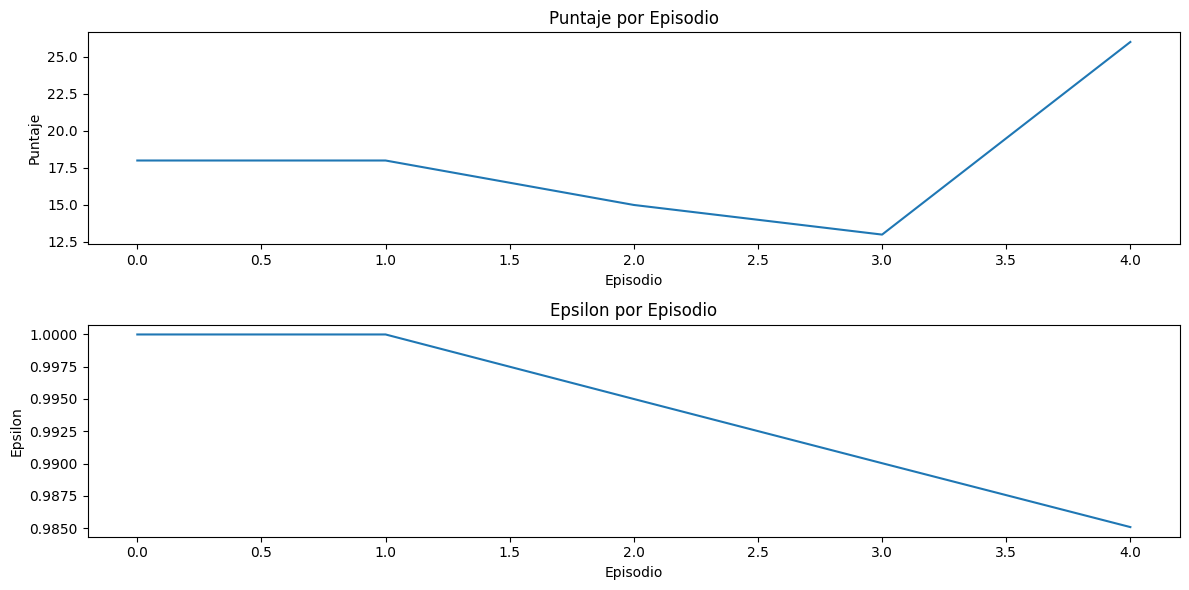

In [61]:
# Graficar resultados
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(scores)
plt.title('Puntaje por Episodio')
plt.xlabel('Episodio')
plt.ylabel('Puntaje')
plt.subplot(212)
plt.plot(epsilons)
plt.title('Epsilon por Episodio')
plt.xlabel('Episodio')
plt.ylabel('Epsilon')
plt.tight_layout()
plt.show()

## Mostrar el video con uso de show_video


In [62]:
# Mostrar el vídeo renderizado como HTML
show_rendered_video = show_video(videopath)
display(HTML(show_rendered_video))

<IPython.core.display.HTML object>

## Mostrar el video con uso de render_mp4


In [63]:
rendered_video = render_mp4(videopath)
display(HTML(rendered_video))